In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def spot_termination_sim(
    runtime_min, spot_termination_rate_per_hr, total_jobs,
    calculation_interval_min=1, job_start_lag_min=2., job_end_lag_min=2.,
    checkpoints=None, max_queue_size=None, quiet=True, between_runs_lag_min=0.
):

    spot_termination_rate_per_int = 1.-(1-spot_termination_rate_per_hr)**(calculation_interval_min/60.)
    if checkpoints is None:
        checkpoints = np.array([])
    use_checkpoints = np.append(checkpoints, runtime_min-calculation_interval_min)
    if max_queue_size is None:
        max_queue_size = total_jobs

    # Initialize variables
    run_count = 1
    instance_minutes = 0
    total_runtime = 0
    job_completion_status = np.zeros(total_jobs)
    # Calculate run performance
    while np.min(job_completion_status) < runtime_min-calculation_interval_min:
        if not quiet:
            print('Beginning run {}'.format(run_count))
            print('Processing {} jobs'.format(
                np.where(job_completion_status < runtime_min-calculation_interval_min)[0].shape[0]
            ))
        if run_count == 1:
            runtime_this_run = 0
        else:
            runtime_this_run = between_runs_lag_min
        job_count = 0
        for job_ind in range(total_jobs):
            if job_completion_status[job_ind] < runtime_min-calculation_interval_min:
                instance_minutes += job_start_lag_min+job_end_lag_min
                for time_min in np.arange(job_completion_status[job_ind], runtime_min, calculation_interval_min):
                    instance_minutes += calculation_interval_min
                    rand = np.random.uniform()
                    if rand < spot_termination_rate_per_int:
                        break
                if job_count == max_queue_size:
                    total_runtime += runtime_this_run
                    runtime_this_run = 0
                    job_count = 0
                job_timing = (
                    time_min - job_completion_status[job_ind] + job_start_lag_min + job_end_lag_min + calculation_interval_min
                )
                if job_timing > runtime_this_run:
                    runtime_this_run = job_timing
                passed_checkpoints = np.where(use_checkpoints-time_min <= 0)[0]
                if passed_checkpoints.shape[0] > 0:
                    job_completion_status[job_ind] = use_checkpoints[passed_checkpoints[-1]]
                job_count += 1
        total_runtime += runtime_this_run
        run_count += 1
    total_runs = run_count-2
    
    return instance_minutes, total_runtime, total_runs

In [3]:
trials = 100
runtime_min = 633.
total_jobs = 100
job_start_lag_min=2.
job_end_lag_min=2.
between_runs_lag_min=240.
n_checkpoints = np.array([0, 1, 2, 10])

spot_termination_rates = np.arange(0,.2,.01)
instance_minutes_arr = np.zeros((np.shape(n_checkpoints)[0], np.shape(spot_termination_rates)[0], trials))
total_runtime_arr = np.zeros((np.shape(n_checkpoints)[0], np.shape(spot_termination_rates)[0], trials))
total_runs_arr = np.zeros((np.shape(n_checkpoints)[0], np.shape(spot_termination_rates)[0], trials))

for checkpoint_ind in range(np.shape(n_checkpoints)[0]):
    if n_checkpoints[checkpoint_ind] > 0:
        checkpoints = np.arange(0, runtime_min, runtime_min/float(n_checkpoints[checkpoint_ind]+1))
    else:
        checkpoints = np.array([])
    for rate_ind, spot_termination_rate_per_run in enumerate(spot_termination_rates):
        for trial_ind in range(trials):
            instance_minutes, total_runtime, total_runs = spot_termination_sim(
                runtime_min, spot_termination_rate_per_run, total_jobs,
                job_start_lag_min=job_start_lag_min, job_end_lag_min=job_end_lag_min,
                checkpoints=checkpoints, between_runs_lag_min=between_runs_lag_min
            )
            instance_minutes_arr[checkpoint_ind, rate_ind, trial_ind] = instance_minutes
            total_runtime_arr[checkpoint_ind, rate_ind, trial_ind] = total_runtime
            total_runs_arr[checkpoint_ind, rate_ind, trial_ind] = total_runs

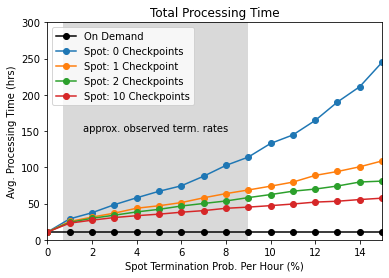

In [63]:
mean_runtime_hrs = np.mean(total_runtime_arr, axis=2)/60.
on_demand_runtime_hrs = np.full(
    np.shape(spot_termination_rates)[0], 
    (runtime_min+job_start_lag_min+job_end_lag_min)/60.
)
plt.figure()
ylim = [0,300]
spot_term_observed_range = [.7,9]
plt.fill(
    [spot_term_observed_range[0], spot_term_observed_range[1], spot_term_observed_range[1], spot_term_observed_range[0]],
    [ylim[0], ylim[0], ylim[1], ylim[1]],
    'black', alpha=0.15
)
plt.plot(spot_termination_rates*100, on_demand_runtime_hrs, '-o', color='black')
for checkpoint_ind in range(np.shape(n_checkpoints)[0]):
    plt.plot(spot_termination_rates*100, mean_runtime_hrs[checkpoint_ind, :], '-o')
plt.xlabel('Spot Termination Prob. Per Hour (%)')
plt.ylabel('Avg. Processing Time (hrs)')
legend_titles = ['On Demand']
for num in n_checkpoints:
    if num == 1:
        legend_titles = np.append(legend_titles, ['Spot: {} Checkpoint'.format(num)])
    else:
        legend_titles = np.append(legend_titles, ['Spot: {} Checkpoints'.format(num)])
plt.ylim(ylim)
plt.xlim([0,15])
plt.legend(legend_titles)
plt.text(np.mean(spot_term_observed_range), 150, 'approx. observed term. rates', horizontalalignment='center')
plt.title('Total Processing Time')
plt.savefig('/Users/ruby/Downloads/sim_spot_time.png', dpi=300)
plt.show()

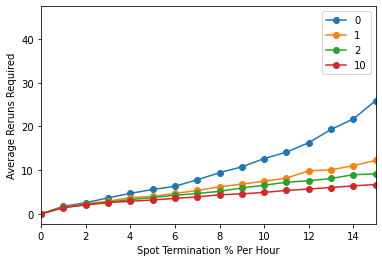

In [6]:
mean_runs = np.mean(total_runs_arr, axis=2)
for checkpoint_ind in range(np.shape(n_checkpoints)[0]):
    plt.plot(spot_termination_rates*100, mean_runs[checkpoint_ind, :], '-o')
plt.xlabel('Spot Termination % Per Hour')
plt.ylabel('Average Reruns Required')
plt.legend(n_checkpoints)
plt.xlim([0,15])
plt.show()

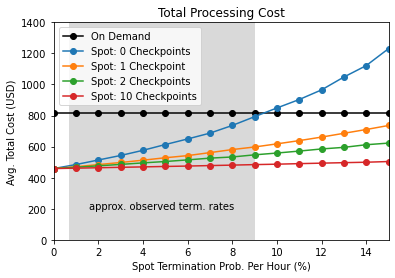

In [62]:
spot_price = .432
on_demand_price = .768
ylim = [0,1400]
avg_cost = spot_price*np.mean(instance_minutes_arr, axis=2)/60.
on_demand_cost = np.full(
    np.shape(spot_termination_rates)[0], 
    on_demand_price*total_jobs*(runtime_min+job_start_lag_min+job_end_lag_min)/60.
)
spot_term_observed_range = [.7,9]
plt.fill(
    [spot_term_observed_range[0], spot_term_observed_range[1], spot_term_observed_range[1], spot_term_observed_range[0]],
    [ylim[0], ylim[0], ylim[1], ylim[1]],
    'black', alpha=0.15
)
plt.plot(spot_termination_rates*100, on_demand_cost, '-o', color='black')
for checkpoint_ind in range(np.shape(n_checkpoints)[0]):
    plt.plot(spot_termination_rates*100, avg_cost[checkpoint_ind, :], '-o')

plt.xlabel('Spot Termination Prob. Per Hour (%)')
plt.ylabel('Avg. Total Cost (USD)')
legend_titles = ['On Demand']
for num in n_checkpoints:
    if num == 1:
        legend_titles = np.append(legend_titles, ['Spot: {} Checkpoint'.format(num)])
    else:
        legend_titles = np.append(legend_titles, ['Spot: {} Checkpoints'.format(num)])
plt.legend(legend_titles)
plt.xlim([0,15])
plt.ylim(ylim)
plt.text(np.mean(spot_term_observed_range), 200, 'approx. observed term. rates', horizontalalignment='center')
plt.title('Total Processing Cost')
plt.savefig('/Users/ruby/Downloads/sim_spot_cost.png', dpi=300)
plt.show()

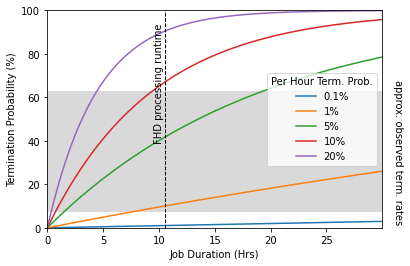

In [65]:
plot_spot_termination_rate_per_hr = [.1, 1, 5, 10, 20]
job_length_hrs = np.arange(0,30,.01)
xlim = [0,np.max(job_length_hrs)]
spot_term_observed_range = [.7,9]
term_prob_observed = [(1.-(1-rate/100.)**(633/60.))*100 for rate in spot_term_observed_range]
plt.fill(
    [xlim[0], xlim[1], xlim[1], xlim[0]],
    [term_prob_observed[0], term_prob_observed[0], term_prob_observed[1], term_prob_observed[1]],
    'black', alpha=0.15
)
for spot_term_rate in plot_spot_termination_rate_per_hr:
    plt.plot(job_length_hrs, (1.-(1-spot_term_rate/100.)**(job_length_hrs))*100)
plt.plot([633/60., 633/60.], ylim, 'black', linestyle='--', linewidth=1)
plt.text(633/60.-1, 40, 'FHD processing runtime', rotation=90)
plt.text(31, np.mean(term_prob_observed), 'approx. observed term. rates', rotation=270, verticalalignment='center')
plt.xlabel('Job Duration (Hrs)')
plt.ylabel('Termination Probability (%)')
plt.ylim([0,100])
plt.xlim(xlim)
lengend_text = ['{}%'.format(rate) for rate in plot_spot_termination_rate_per_hr]
plt.legend(lengend_text, title='Per Hour Term. Prob.')
plt.savefig('/Users/ruby/Downloads/term_prob.png', dpi=300)
plt.show()